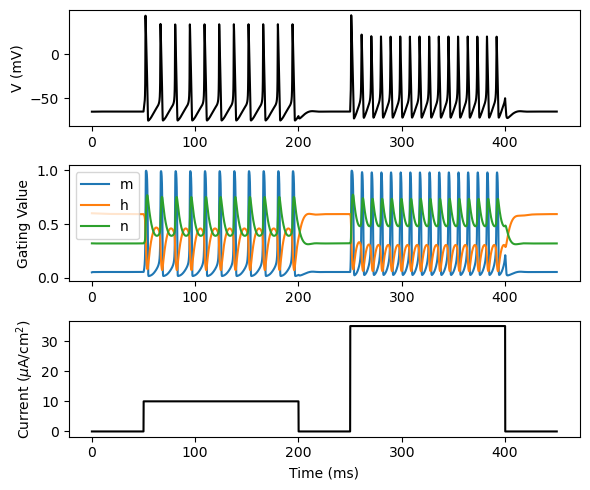

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 定数の定義
class HHParameter:
    def __init__(self):
        self.Cm = 1.0  # 膜容量 (uF/cm^2)
        self.gNa = 120.0  # Na+ 最大コンダクタンス (mS/cm^2)
        self.gK = 36.0  # K+ 最大コンダクタンス (mS/cm^2)
        self.gL = 0.3  # 漏れ電流の最大コンダクタンス (mS/cm^2)
        self.ENa = 50.0  # Na+ 平衡電位 (mV)
        self.EK = -77.0  # K+ 平衡電位 (mV)
        self.EL = -54.0  # 漏れ電流の平衡電位 (mV)
        self.tr = 0.5  # ms
        self.td = 8.0  # ms
        self.invtr = 1.0 / self.tr
        self.invtd = 1.0 / self.td
        self.v0 = -20.0  # mV

class HH:
    def __init__(self, N=1):
        self.param = HHParameter()
        self.N = N
        self.v = np.full(N, -65.0)
        self.m = np.full(N, 0.05)
        self.h = np.full(N, 0.6)
        self.n = np.full(N, 0.32)
        self.r = np.zeros(N)

def update(variable, param, Ie, dt):
    N = variable.N
    v, m, h, n, r = variable.v, variable.m, variable.h, variable.n, variable.r
    Cm, gNa, gK, gL, ENa, EK, EL, invtr, invtd, v0 = (
        param.Cm, param.gNa, param.gK, param.gL,
        param.ENa, param.EK, param.EL, param.invtr, param.invtd, param.v0
    )
    
    for i in range(N):
        alpha_m = 0.1 * (v[i] + 40) / (1 - np.exp(-0.1 * (v[i] + 40)))
        beta_m = 4 * np.exp(-(v[i] + 65) / 18)
        alpha_h = 0.07 * np.exp(-0.05 * (v[i] + 65))
        beta_h = 1 / (1 + np.exp(-0.1 * (v[i] + 35)))
        alpha_n = 0.01 * (v[i] + 55) / (1 - np.exp(-0.1 * (v[i] + 55)))
        beta_n = 0.125 * np.exp(-0.0125 * (v[i] + 65))

        m[i] += dt * (alpha_m * (1 - m[i]) - beta_m * m[i])
        h[i] += dt * (alpha_h * (1 - h[i]) - beta_h * h[i])
        n[i] += dt * (alpha_n * (1 - n[i]) - beta_n * n[i])

        INa = gNa * m[i]**3 * h[i] * (v[i] - ENa)
        IK = gK * n[i]**4 * (v[i] - EK)
        IL = gL * (v[i] - EL)

        v[i] += dt / Cm * (Ie[i] - INa - IK - IL)
        r[i] += dt * ((invtr - invtd) * (1 - r[i]) / (1 + np.exp(-v[i] + v0)) - r[i] * invtd)

# HHNeuronクラスの実装
class HHNeuron:
    def __init__(self, units: int):
        self.units = units
        self.v = np.full((units, 1), -65.0)
        self.m = np.full((units, 1), 0.05)
        self.h = np.full((units, 1), 0.6)
        self.n = np.full((units, 1), 0.32)
        self.param = HHParameter()

    def step(self, reservoir, x: np.ndarray) -> np.ndarray:
        Cm, gNa, gK, gL, ENa, EK, EL = (
            self.param.Cm, self.param.gNa, self.param.gK, self.param.gL,
            self.param.ENa, self.param.EK, self.param.EL
        )

        u = x.reshape(-1, 1)  # 外部入力 (nA)
        r = reservoir.state().T  # スパイク入力

        W = np.abs(reservoir.W)
        Win = np.abs(reservoir.Win)
        bias = reservoir.bias
        g_in = reservoir.noise_in
        dist = reservoir.noise_type
        noise_gen = reservoir.noise_generator

        I_ext = np.array(
            W @ r + Win @ (u + noise_gen(dist=dist, shape=u.shape, gain=g_in)) + bias
        )

        alpha_m = 0.1 * (self.v + 40) / (1 - np.exp(-0.1 * (self.v + 40)))
        beta_m = 4 * np.exp(-(self.v + 65) / 18)
        alpha_h = 0.07 * np.exp(-0.05 * (self.v + 65))
        beta_h = 1 / (1 + np.exp(-0.1 * (self.v + 35)))
        alpha_n = 0.01 * (self.v + 55) / (1 - np.exp(-0.1 * (self.v + 55)))
        beta_n = 0.125 * np.exp(-0.0125 * (self.v + 65))

        self.m += alpha_m * (1 - self.m) - beta_m * self.m
        self.h += alpha_h * (1 - self.h) - beta_h * self.h
        self.n += alpha_n * (1 - self.n) - beta_n * self.n

        INa = gNa * self.m**3 * self.h * (self.v - ENa)
        IK = gK * self.n**4 * (self.v - EK)
        IL = gL * (self.v - EL)

        self.v += (I_ext - INa - IK - IL) / Cm

        spikes = self.v >= 0  # スパイクしたかどうかを判定 (V >= 0)
        self.v[spikes] = -65.0  # スパイク後の電位リセット

        return spikes.astype(np.float32).T

# シミュレーションの設定
T = 450.0  # ms
dt = 0.05  # ms
nt = int(T / dt)  # 時間ステップ数
N = 1  # ニューロンの数

t = np.arange(1, nt + 1) * dt
Ie = 10.0 * ((t > 50) & (t <= 200)) + 35.0 * ((t > 250) & (t <= 400))  # 刺激電流
Ie = np.tile(Ie, (N, 1)).T

# 記録用
varr = np.zeros((nt, N))
gatearr = np.zeros((nt, N, 3))

# モデルの定義
neurons = HH(N=N)

# シミュレーション
for i in range(nt):
    update(neurons, neurons.param, Ie[i, :], dt)
    varr[i, :] = neurons.v
    gatearr[i, :, :] = np.array([neurons.m, neurons.h, neurons.n]).T

# プロット
fig, axs = plt.subplots(3, 1, figsize=(6, 5))

axs[0].plot(t, varr[:, 0], color="black")
axs[0].set_ylabel("V (mV)")

labellist = ["m", "h", "n"]
for i in range(3):
    axs[1].plot(t, gatearr[:, 0, i], label=labellist[i])
axs[1].set_ylabel("Gating Value")
axs[1].legend()

axs[2].plot(t, Ie[:, 0], color="black")
axs[2].set_ylabel("Current ($\mu$A/cm$^2$)")
axs[2].set_xlabel("Time (ms)")

plt.tight_layout()
plt.show()
